<a href="https://colab.research.google.com/github/zipped1/Greenhouse-Report/blob/master/notebooks/Pallet_degradationTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ccc-frankfurt/aisel-palletdegr/blob/main/notebooks/Pallet-degradation.ipynb)

# Pallet degradation detection for Euro-pallets
## A hybrid-based approach 
## 1 Introduction
In this document we will guide you through the creation of a hybrid system combining data driven and model base approaches to detect pallets and estimate their level of degradation. 🤣🤣 asdsadda<sd

## 2 Setup
Before we get started we first set up some settings and functions in order to provide an easier workflow later.

### 2.2 Load and configure Matplotlib for use in Jupyter notebook

We want Matplotlib figures to appear within the notebook rather than inside a separate window, so we make use of the `%matplotlib` function to set the [Matplotlib backend](https://matplotlib.org/tutorials/introductory/usage.html#backends) to `inline`. This way the figure appears right after the cell where the [show](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.show.html?highlight=show#matplotlib.pyplot.show) method has been called.

In [ ]:
%matplotlib inline

import matplotlib
from   matplotlib import pyplot as plt

In [ ]:
# Set default color map and interpolation method for images.
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

### 2.3 Define function to display images
During this project we will generate a lot of images and manually plotting them all would be a lot of repetitive code. So instead we implement the following `render` function.

The function creates and displays a figure of size `width` times `height`, both measured in inches. The third argument to the function is an array of tuples, where each tuple consists of an image, a title and an integer that is a valid subplot position, so that we can control where in the figure the image should appear.

**NOTE**: A color image read with OpenCV is in *Blue-Green-Red (BGR)* mode, but Matplotlib displays images in *RGB* mode. To display images with our render function we thus have to convert them to *RGB*.

In [ ]:
def render(width, height, args):
    """
    Render multiple images into a new figure.
    For each subplot provide a tuple with image, title and position.
    """
    plt.figure(figsize = (width, height))

    for img, title, position in args:

        # Create titled subplot at given position.
        plt.subplot(position)
        plt.title(title)

        # Prevent labelling of the axis.
        plt.xticks([])
        plt.yticks([])

        # Render image into current subplot.
        plt.imshow(img)

    # Display the figure.
    plt.show()

## 3 Convolutional neural network
We start with a convolutional neural network

In [ ]:
#import os modules
from os import listdir
#import mask-rCNN modules
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.model import load_image_gt
from mrcnn.config import Config
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
#import numpy modules
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
#import matplotlib modules
from matplotlib import pyplot
from matplotlib.patches import Rectangle

Using TensorFlow backend.


In [ ]:
# define a configuration for the model
class PaletteConfig(Config):
    # define the name of the configuration
    NAME = "palette_cfg"
    # number of classes (background + palette)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 131

In [ ]:
def load_dataset(dataset_dir):
    
    train_set = Dataset()
    test_set = Dataset()
    # define one class
    train_set.add_class("dataset", 1, "palette")
    test_set.add_class("dataset", 1, "palette")
    # define data locations
    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annots/'
    
    image_list = listdir(images_dir)
    
    test_ratio = round(len(image_list)*(0.7))
    test_ratio = round(len(image_list)*(0.3))
    
    test_dir = image_list[:test_ratio]
    train_dir = image_list[-test_ratio:]
    
    
    # find all images
    for image in train_dir:
    
        image_id = image[5:]
    
        img_path = images_dir + image
        ann_path = annotations_dir + image_id + '.xml'
        # add to dataset
        train_set.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    for image in test_dir:
    
        image_id = image[5:]
    
        img_path = images_dir + image
        ann_path = annotations_dir + image_id + '.xml'
        # add to dataset
        test_set.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    return train_set, test_set

In [ ]:
train_set, test_set = load_dataset('../datasets/palette')

## 4 Model-based pallet detection
Theoretically we could take the found positions for granted.🙀 But the CNN makes mistakes sometimes🙄 and finds pallet a little bit shifted or misplaced or even in places, where no pallet exists at all🤐 as seen below: (TODO: Images have to be created)

We could improve the network architecture or train it on more data in order to improve its performance, but the network remains non interpretable and might thus break under new conditions and we wouldn't know why.
Hence we add a model-based approach which evaluates the position and even adjusts them a little if necesarry.

### 4.1 Feature extraction
Our handcrafted approach is based on the occurence of features, so we'll start y having a look at some useful features

#### 4.1.1 Simple Edge and corner detectors
Euro-pallets have a lot of characteristic edges and corners, we can make use of. We'll start by reading the images (original and in grayscale) and resizing them in order to change the effect of the later applied filters, making some of them more effective.

First we will apply some basic edge and corner detectors included in the openCV library. 

In [ ]:
import cv2
import numpy as np

# read image from dataset directory
filename = "../datasets/palette/images/00013.jpg"
img = cv2.imread(filename, cv2.IMREAD_COLOR) # color image in Blue-Green-Red (BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # color image in Red-Green-Blue (RGB, Matplotlib requires RGB)
img_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) # Image in greyscale

def shrink_h(img, h_des):
    # shrinking the images to a desired height, while keeping the side ratio (w / h) constant
    h = img.shape[0]
    w = img.shape[1]
    w_des = int(h_des * w / h) # desired width
    return cv2.resize(img, (w_des, h_des))


First we apply the Canny edge detector on the original and a shrinked Image:


(100, 93, 3)


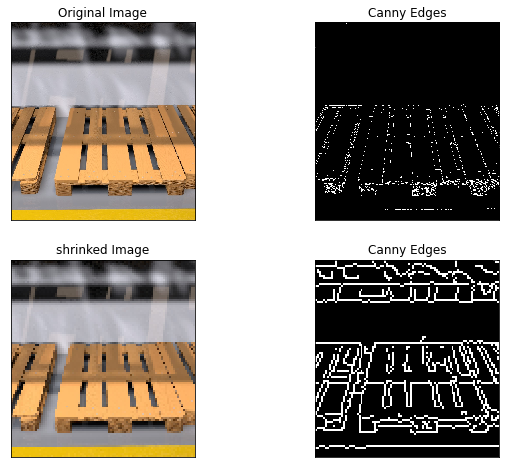

In [ ]:
# setting h to 100
img_small = shrink_h(img, 100)

# extract Canny edges
canny = cv2.Canny(img, 100, 200)
canny_small = cv2.Canny(img_small, 100, 200)

render(10, 8, [
    (img, 'Original Image', 221),
    (canny, 'Canny Edges', 222),
    (img_small, 'shrinked Image', 223),
    (canny_small, 'Canny Edges', 224)
    
])

We observe that the canny edges  are especially activated by the woodstructure in the original sized image, making it a good feature instance for (wooden-) pallet recognition.

Applying Canny edge to the shrinked image highlights the outline of the pallet pretty good and also captures the border of the shadow unedrneath the pallet.

Next we apply the Sobel edge detector. The Sobel edge detector calculates the intensities gradient at each position.
We apply the sobel filter on the grayscale image as it, unlike the Canny filter, does not automatically convert the image to greyscale.

The gradient can be negative, when switching from light to dark, which can't be represented by regular integers of type `CV_8U` which we use to represent the image intensities (0 to 255). We thus calculate the gradient in the data type `CV_64F` allowing negative values, take the absoulue value and then transform it back to `CV_8U`

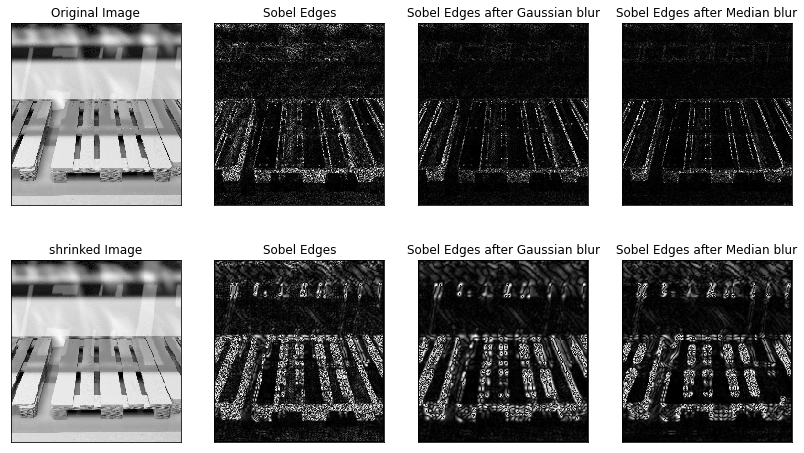

In [ ]:
# shrink grayscale image
img_gray_small = shrink_h(img_gray, 200)

def sobel_edges(img_gray):
    # extract Sobel edges from unchanged grayscale image
    # Output dtype = cv2.CV_64F. Then take its absolute and convert to cv2.CV_8U
    sobelx64f = cv2.Sobel(img_gray, cv2.CV_64F, 1, 1, ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    return np.uint8(abs_sobel64f)

# Apply Sobel-Filter
sobel = sobel_edges(img_gray)
sobel_small = sobel_edges(img_gray_small)

# Apply gaussian blur to image
img_gray_gaussian =  cv2.GaussianBlur(img_gray, (9, 9), 1) 
img_gray_gaussian_small = cv2.GaussianBlur(img_gray_small, (9, 9), 1)


# Apply median blur to image
img_gray_median =  cv2.medianBlur(img_gray, 5)  
img_gray_median_small =  cv2.medianBlur(img_gray_small, 5)

# Apply sobel
sobel_gaussian = sobel_edges(img_gray_gaussian)
sobel_gaussian_small = sobel_edges(img_gray_gaussian_small)
sobel_median = sobel_edges(img_gray_median)
sobel_median_small = sobel_edges(img_gray_median_small)


render(14, 8, [
    (img_gray, 'Original Image', 241),
    (sobel, 'Sobel Edges', 242),
    (sobel_gaussian, 'Sobel Edges after Gaussian blur', 243),
    (sobel_median, 'Sobel Edges after Median blur', 244),
    (img_gray_small, 'shrinked Image', 245),
    (sobel_small, 'Sobel Edges', 246),
    (sobel_gaussian_small, 'Sobel Edges after Gaussian blur', 247),
    (sobel_median_small, 'Sobel Edges after Median blur', 248)
])

TODO: Interpretieren

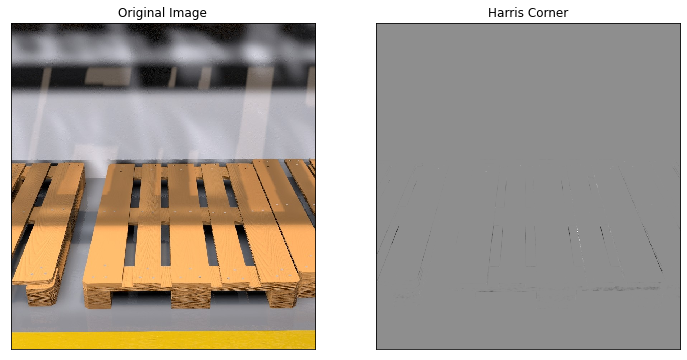

In [ ]:
# extract Harris corners
harris = cv2.cornerHarris(img_gray, 2, 3, 0.05)

render(12, 8, [
    (img, 'Original Image', 121),
    (harris, 'Harris Corner', 122)
])

#### 4.1.2 Black box detection

In [ ]:
# Missing so far

### 4.2 Activation / Dilation
We will later try to distinguish whether a contains a pallet or not based on the occurence of features. But one certain feature will not always occure in the exact same pixel. (TODO: This could be shown with the difference between two images with features)

In order to allow slight displacements, we apply Dilation s.t. a certain pixel is always activated when a feature is detected in a certain radius

### 4.3 Likelihood template
Explain assumend distribution.

### 4.4 Detecting missing parts
A single missing part of a pallet might cause that the pallet is not found at all, as the areas of the missing parts is dragging the whole likelihood temlate down with its unusual pattern.
We thus evaluate single parts of the pallet separately and are thus not only able to find damaged pallets but can also spot the missing components. 

### 4.5 Adjust position via gradient descent
The positions are adjustet in all possible dimensions (Rotation around vertical axis, and three dimensional shift in 3D)

### 4.6 Further degradation estimators 
Not yet designed. Extract colors or cracks, etc.

## 5 Evaluation and testing
Testing is not yet planned. Should run with simulation data as well as real data.

In [ ]:
# Testing and evaluation